In [1]:
import numpy as np
import odl
import scipy.misc
import Operators as op
from Operators import soft_shrinkage
from TVRegularise import TVregularize
from scipy.signal import convolve2d
from numpy.fft import fftn, ifftn, fftshift, ifftshift

In [2]:
import matplotlib.pyplot as plt
import SensingMatrix as sm
import Measurements as me
from SetUpImage import setUpImage
from DisplaysFast import phase_retrie_plots
from DisplaysFast import phase_retrie_plots_desk
from DisplaysFast import phase_retrie_plots_objects
from DisplaysFast import phase_retrie_plots_noPlot
from DisplaysFast import phase_retrie_plots_noPlot_full_error
import imageio
import io

In [3]:
def plot_image(img, title, cmap='gray', vmin=None, vmax=None):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 1, 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.colorbar()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.ndimage import binary_erosion

def extend_support_with_holes(image, dilation_radius=1):
    """
    Extend the support (boundary) of the shape in the image by ones using dilation,
    while preserving the holes inside the support shape.
    
    Args:
    - image (np.ndarray): The binary image with the support shape.
    - dilation_radius (int): The radius by which to extend the support region.
    
    Returns:
    - np.ndarray: The padded image with extended support and preserved holes.
    """
    # Erosion to find the outer boundary of the object
    eroded_image = binary_erosion(image).astype(int)

    
    # Perform binary dilation with a square structuring element
    structure = np.ones((dilation_radius * 2 + 1, dilation_radius * 2 + 1), dtype=bool)
    dilated_image = binary_dilation(image, structure=structure).astype(int)
    
    # Mask out the holes: keep original zero regions that were zeros in the input
    # extended_image = np.where(image == 0, dilated_image, image)
    extended_image = dilated_image * image + image
    return extended_image, eroded_image



## Set up test images and different masks  

In [5]:
half_Nx, half_Ny = 34, 34
#half image shape
Nx, Ny = 2 * half_Nx + 1,  2 * half_Ny + 1 #image shape
rx, ry = 1, 1 #for oversampling
n = Nx * Ny #image size

# object support
Kx = 4 * (half_Nx)// 10 # half_Nx #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).  
Ky = 4 * (half_Ny)// 10 # half_Ny #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).

# mask support
tx = 0. #parameter between 0 (very precise) and 1(no support knowledge) # 0.35  failed already
ty = 0. #parameter between 0 (very precise) and 1(no support knowledge)  

#true_images = setUpImage(Nx, Ny)
s = setUpImage(Nx, Ny, Kx, Ky, tx, ty)

true_images, mask, mask_shepp, exact_mask_shepp, extended_mask_shepp, mask_cancer = s()
# print(true_images[1].shape)
# print(mask.shape)


### Plot all test images 

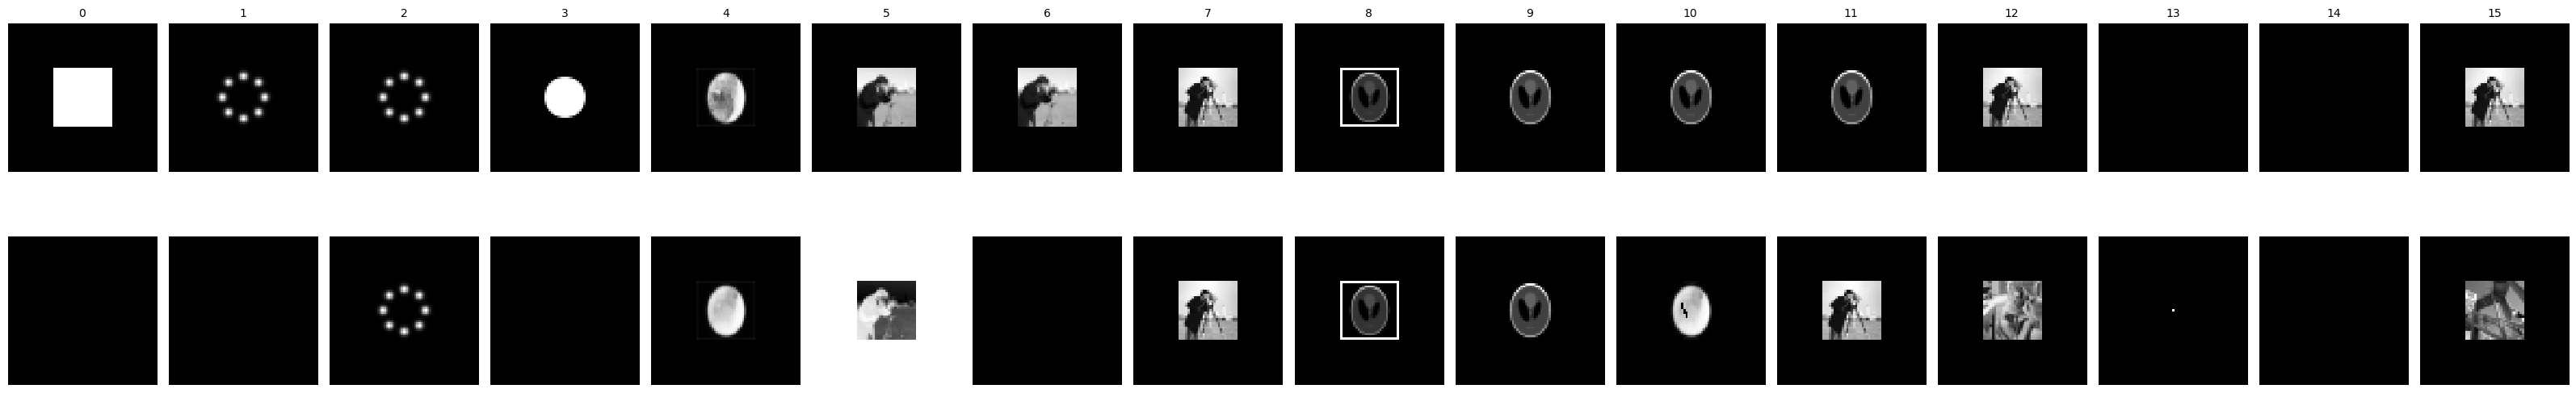

In [6]:
def plot_all_test_images(true_images, titles):
    N = len(true_images) 
    fig = plt.figure(figsize=(32, 16))
    for i, x0 in enumerate(true_images):
        ax = fig.add_subplot(6, N, i+1)
        im = ax.imshow(x0.real, vmin=np.min(x0.real), vmax=np.max(x0.real), interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(f'{i}', fontsize=10) # ax.set_title(f'{titles[i]}', fontsize=10)
        ax.axis('off')
        # plt.colorbar(im, ax=ax)
        
        ax1 = fig.add_subplot(6, N, i + 1 + N)
        im = ax1.imshow(x0.imag, vmin=np.min(x0.imag), vmax=np.max(x0.imag), interpolation="nearest", cmap=plt.cm.gray)
        # ax1.set_title(f'{titles[i + N]}', fontsize=10)
        ax1.axis('off')
        # plt.colorbar(im, ax=ax1)
    # Create a BytesIO buffer to save the image
    buffer = io.BytesIO()
    
    # Save the plot to the buffer instead of a file
    plt.savefig(buffer, format='png', dpi=300)
    caption = buffer.getvalue()
    buffer.seek(0)
    plt.tight_layout()
    plt.show()
    return caption
titles = []  #* len(true_images)
caption = plot_all_test_images(true_images, titles)

In [7]:
# importance of phase
# plt.title("Original Support Shape")
im1 = true_images[7].real
im2 = true_images[0].real
fim1 = np.fft.fft2(im1)
fim2 = np.fft.fft2(im2)
ifim2 = np.fft.ifft2(fim2)
m1p2 = np.fft.ifft2( np.abs(fim1)*np.angle(fim2) )
m2p1 = np.fft.ifft2( np.abs(fim2)*np.angle(fim1) )


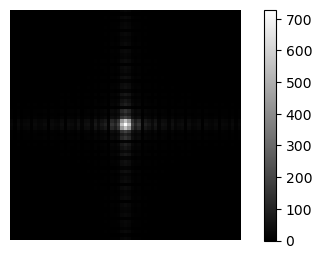

In [8]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 1, 1)
plt.imshow((np.fft.fftshift(np.abs(fim2))), cmap='gray') #np.fft.fftshift(np.abs(fim1))
# im = plt.imshow((ifim2.real), cmap='gray') #np.fft.fftshift(np.abs(fim1))
plt.axis('off')
plt.colorbar()
plt.show()
path = 'camPhase'  # 'camerama'
# (np.abs(fim2)).max()
# plt.savefig(path, dpi=300)

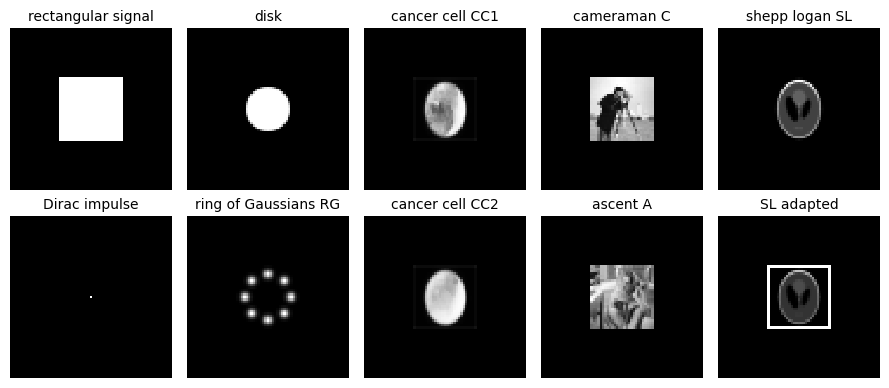

In [9]:

def plot_test_images(true_images, titles):
    N = 5 #len(true_images) 
    fig = plt.figure(figsize=(9, 4))
    for i in range(N):
        x0 = true_images[i ]
        ax = fig.add_subplot(2, 1*N, i+1)
        im = ax.imshow(x0.real, vmin=np.min(x0.real), vmax=np.max(x0.real), interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(f'{titles[i]}', fontsize=10) # ax.set_title(f'{i}', fontsize=10) # ax.set_title(f'{titles[i]}', fontsize=10)
        ax.axis('off')
        # plt.colorbar(im, ax=ax)
        
        ax1 = fig.add_subplot(2, 1*N, i + 1 + N)
        x0 = true_images[i + N]
        im = ax1.imshow(x0.imag, vmin=np.min(x0.imag), vmax=np.max(x0.imag), interpolation="nearest", cmap=plt.cm.gray)
        ax1.set_title(f'{titles[i + N]}', fontsize=10)
        ax1.axis('off')
        # plt.colorbar(im, ax=ax1)
    # Create a BytesIO buffer to save the image
    buffer = io.BytesIO()
    
    # Save the plot to the buffer instead of a file
    plt.savefig(buffer, format='png', dpi=300)
    caption = buffer.getvalue()
    buffer.seek(0)
    plt.tight_layout()
    plt.show()
    return caption
    
# titles = ['rectangular signal', 'ring of Gaussians RG', 'RGiRG', 'disk ', 'cancer cell CC',  'cameraman C',  'CiC', 'Ci-C',  'SLiSL adapted', '(1 + i) shepp logan SL', 'SLiCC', 'SLiC', '(1-i) ascent', 'dirac']  #* len(true_images)
titles = ['rectangular signal', 'disk',                              'cancer cell CC1',  'cameraman C', 'shepp logan SL', 
          'Dirac impulse'     , 'ring of Gaussians RG'              ,'cancer cell CC2',  'ascent A' ,   'SL adapted'
         ]  #* len(true_images)
list = [true_images[i] for i in np.array([0,  3, 4, 7, 9,
                                          13, 2, 4, 12, 8 ])]
caption = plot_test_images(list, titles)
path = 'results_desk/test images2.jpeg' # /object_image_ratio_4over10/Fourier/noiseless/gaussian_init/shepp cancer same support, Gauss DRS, 4 over 10, extended shepp mask, 84_84 x 2,noiseless, gaussian init, 1000 iter.png'
# with open(path, 'wb') as f:
#     f.write(caption)

In [10]:
from PIL import Image
imgc = Image.open('ISIC_0000004_cancer.jpg')
#img = iio.v2.imread('ISIC_0000004_cancer.jpg')
#x_true = Image.rgb2gray(img)
#print('true_support.shape', true_support.shape)
x_true3 = np.array(imgc) #.resize((self.Nx, self.Ny))

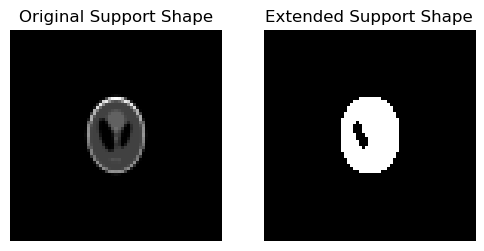

In [11]:
# Example usage
# Create a binary image with an initial shape (for demonstration, a circle)
image_size = (100, 100)
image = np.zeros(image_size)

# Let's add a simple circular shape (support) to the image
center = (50, 50)
radius = 15
for x in range(image_size[1]):
    for y in range(image_size[0]):
        if ( x - center[1])**2 / 4 + (y - center[0])**2 / 1 <= radius**2:
            image[y, x] = 1
image = true_images[10].real
# Extend the support by a factor of 3 (radius of 3 pixels)
extended_image, eroded_image = extend_support_with_holes(image, dilation_radius=4)

# Plot the original and extended images
plt.figure(figsize=(6, 3))

# Plot original image
plt.subplot(1, 2, 1)
plt.title("Original Support Shape")
plt.imshow(image, cmap='gray')
plt.axis('off')

# Plot extended support shape
plt.subplot(1, 2, 2)
plt.title("Extended Support Shape")
plt.imshow(eroded_image, cmap='gray')
plt.axis('off')

plt.show()


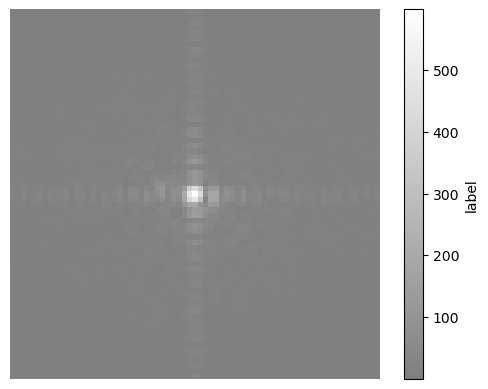

(array([8]), array([46]))

In [12]:
# Create a figure and axis
fig, ax = plt.subplots()

# Display the first image
# ax.imshow(extended_mask_shepp.real, alpha=.5, cmap='gray')

# Overlay the second image
image = true_images[12]# .real + 1j* true_images[9].imag
# image = np.fliplr (np.flipud(image))
# image = np.abs(image)*np.exp( 1j * ((np.pi / 2)  - np.angle(image)))
im = image.imag
fimage = np.fft.fft2(image)
magn = np.fft.fftshift(np.abs(fimage))
img = ax.imshow( (magn), alpha=.5, cmap='gray') # np.fft.ifftshift
# img.save('cancer cell has full rectangular support.jpg')
plt.colorbar(img, ax=ax, label='label', cmap='gray')
# Remove axis
ax.axis('off') 
# plt.savefig('shepp spectrum, halfs are 84 x 84.jpg', dpi=300) # results_desk/new_mask/
# plt.savefig('shepp spectrum artificial rectangular support, halfs are 84 x 84.jpg', dpi=300) # results_desk/new_mask/
# plt.savefig('shepp artificial rectangular support, halfs are  84 x 84.jpg', dpi=300) # results_desk/new_mask/
# plt.savefig('shepp, halfs are  84 x 84.jpg', dpi=300) # results_desk/new_mask/
# plt.savefig('results_desk/new mask/cancer cell has full rectangular support, to see, set halfs Nx to 14.jpg', dpi=300)

# plt.colorbar(img, ax = ax)
# Show the result
plt.show()
x_true3[:, :, 0]

magn.min() #  - magn.T
np.where(magn == magn.min())
# magn[17, 159]
# np.abs(fimage[17 - 84, 159 - 84])
# np.angle(fimage[17 - 84, 159 - 84])
# fimage[17 - 84, 159 - 84]

## Get the measurement operator A ready

In [13]:
import time
x_true = true_images[1]
#x_true_vect = x_true.reshape(Nx * Ny, )
#X = [x_true_vect,  x_true_vect]
# X_true_vect = ((1. + 0.j)*np.random.normal(0.5, 0.25, size = (n, ) )) +  (0. + 1.j)*np.random.normal(0.5, 0.25, size = (n, ) )
#print("x_true_vect", x_true_vect)
#x = (1 + 2j)*np.ones(x_true_vect.shape)

#noise_lvl = 0.e-4
start = time.time()
A = sm.iid_stdd_Gauss(Nx, Ny, rx, ry) #sm.FourierMatrix(Nx, Ny, rx, ry) #sm.iid_stdd_Gauss(Nx, Ny, rx, ry)
end = time.time()
end - start
# np.linalg.norm(A.Matrix)

86.43905901908875

### look into the magnitudes as you constraint the support. 
Uncomment the cell below

1.0631165870154942

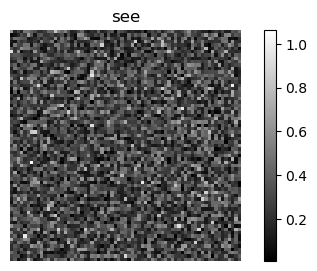

In [14]:
# # object support
# Kx = 5 * (half_Nx)// 10 # half_Nx #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).  
# Ky = 5 * (half_Ny)// 10 # half_Ny #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).
# # mask support
# tx = 0. #parameter between 0 (very precise) and 1(no support knowledge) # 0.35  failed already
# ty = 0. #parameter between 0 (very precise) and 1(no support knowledge)  
# #true_images = setUpImage(Nx, Ny)
# s = setUpImage(Nx, Ny, Kx, Ky, tx, ty)
# true_images, mask, mask_shepp, exact_mask_shepp, extended_mask_shepp, mask_cancer = s()

x_true = true_images[12]
x_true_vect = x_true.reshape(Nx * Ny, )
Ax = A(x_true_vect)
ima = np.abs(Ax)
plot_image(ima.real, 'see', cmap='gray', vmin=None, vmax=None)

ima.max() - 0 * ima.min()

# len(x_true_vect)


In [15]:

def spectInitf(meas, A):
    n = A.shape[1]
    m = A.shape[0]
    
    # Sum of measurements
    s1 = np.sum(meas)
    
    # Optimized sum of squared rows of A (avoiding the loop)
    s2 = np.sum(np.abs(A)**2, axis=1).sum()
    # Compute lambda directly
    lamda = np.sqrt(n * s1 / s2)
    
    # Optimized computation of Y
    Y = np.conjugate(A).T @ np.diag(meas) @ A
    # print('Yf', Y)
    
    # Efficient eigenvalue computation
    eigenval, eigenvect = np.linalg.eig(Y)
    
    # Extract the eigenvector corresponding to the largest eigenvalue
    x0 = eigenvect.real[eigenval.real == max(eigenval.real)][0]  #Complex eigenvalues
    # x0 = eigenvect[:, np.argmax(eigenval)].real
    
    # Normalize the eigenvector
    x0 = x0 * (lamda / np.linalg.norm(x0))
    
    return [x0, eigenval, eigenvect]


In [16]:
import odl
print(odl.__version__)
import solve
#visualize A
# x = 1 *(np.abs(A.Matrix))
# x = (x - np.min(x)) / (np.max(x) - np.min(x))
# img = plt.imshow(x, vmin=np.min(x), vmax=np.max(x), alpha=1, cmap='gray') #- np.log(np.abs(A.Matrix))
# plt.colorbar(img, label='label', cmap='gray')


0.8.1


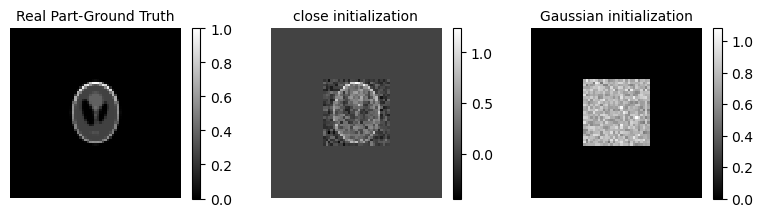

In [17]:
# Initialization images
noise_lvl = 0.00
chosen_mask = mask
x_true = true_images[10]
x_true_vect = x_true.reshape(-1)
# Generate noisy measurements
meas, noise, NSR = me.gauss_noisy_meas(x_true_vect, noise_lvl, A)()
# print('Noise to Signal Ratio (in the 2-norm) :', NSR)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(4, 3, 1)
im = ax.imshow(x_true.real, vmin=np.min(x_true.real), vmax=np.max(x_true.real), interpolation="nearest", cmap=plt.cm.gray)
ax.set_title('Real Part-Ground Truth', fontsize=10)
ax.axis('off')
plt.colorbar(im, ax=ax)
noise_lvls_init = np.array([0.8, 0.01])
for i, init in enumerate(['close', 'Gaussian' ]):
    noise_lvl_init =  noise_lvls_init[i]
    x0, init_NSR = op.initialise(n, meas, A.Matrix, type=init, real=1, imag=1, x_true_vect=x_true_vect, mask=chosen_mask, noise_lvl=np.sqrt(noise_lvl_init))
    x0 = x0.reshape(mask.shape)
    ax = fig.add_subplot(4, 3, i+2)
    im = ax.imshow(x0.real, vmin=np.min(x0.real), vmax=np.max(x0.real), interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(f'{init} initialization', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax)
# Create a BytesIO buffer to save the image
buffer = io.BytesIO()

# Save the plot to the buffer instead of a file
plt.savefig(buffer, format='png', dpi=300)
caption = buffer.getvalue()
buffer.seek(0)
plt.tight_layout()
plt.show()
path = 'results_desk/initialization.jpeg' # /object_image_ratio_4over10/Fourier/noiseless/gaussian_init/shepp cancer same support, Gauss DRS, 4 over 10, extended shepp mask, 84_84 x 2,noiseless, gaussian init, 1000 iter.png'
# with open(path, 'wb') as f:
#     f.write(caption)
    

## Reconstruction algorithms

In [18]:
def phase_retrieval(noise, Algo, map, mask, n, Af, A, A_pinv, meas, maxiter, x, x_true_vect, params):
    # Parameters initialization
    kappa = params.get('kappa', 0.0)
    xi = params.get('xi', 0.0)
    AAR_lambda = params.get('AAR_lambda', 1.0)
    RAAR_beta = params.get('RAAR_beta', 0.5)
    IO_beta = params.get('IO_beta', 1.0)
    OO_beta = params.get('OO_beta', 0.5)
    HIO_beta = params.get('HIO_beta', 1.0)
    [alph, bet, gamm] = params.get('newHIO_alph_beta_gamm', [0.25, 0.25, 0.5])
    TvIter = params.get('TvIter', 10)
    TvAlpha = params.get('TvAlpha', 0.005)
    rho_alph_Gau = params.get('rho_alph_Gau',  [1, 0.5])
    rho_alph_Poi = params.get('rho_alph_Poi',  [1, 0.5])

    gamma_M = params.get('gamma_M', 1)
    gamma_S = params.get('gamma_S', 1)
    # Operators definition
    def P_S(x):
        x = x.copy()
        indices = np.logical_not(mask.reshape((n,)))
        x[indices] = 0
        return x 
    
    def P_M(x):
        X = Af(x).flatten() 
        X = (meas**0.5) * np.exp(1j * np.angle(X))
        return A_pinv(X)

    def R_M(x):
        return (1 + gamma_M) * P_M(x) - gamma_M * x

    def R_S(x):
        return (1 + gamma_S) * P_S(x) - gamma_S * x

    space = odl.uniform_discr(min_pt=[0, 0], max_pt=mask.shape, shape=mask.shape, dtype='complex64')
    x0 = space.zero() 
    Mask = space.element(mask)

    def TV(x, space, x0, Mask, TvIter, supportPrior='no'):
                    ########## TV Regularization ####################
            y_real = space.element(x.real.reshape(mask.shape))
            y_imag = space.element(x.imag.reshape(mask.shape))
            xr = x0
            xi = x0
            TVregularize(y_real, TvAlpha, Mask, xr, space, niter=TvIter, supportPrior=supportPrior)
            if np.linalg.norm(y_imag) > 1e-3:
                TVregularize(y_imag, TvAlpha, Mask, xi, space, niter=TvIter, supportPrior=supportPrior)
            lincomb = odl.LinCombOperator(space, 1, 1.j)
            XX = odl.ProductSpace(space, space)
            xx = XX.element([xr, xi])
            x = space.element(x.reshape(mask.shape))
            lincomb(xx, out=x)
            x = op(x)
            x = x.__array__()
            return x
    
    op = odl.FlatteningOperator(space)
    iterates = [x]
    
    if Algo in ['real mirror', 'complex mirror']:
        x = P_S(x)
        L = 1 * op.smoothnessPara_L(Af.Matrix, noise)
        a, b = (1., 0.) if Algo == 'real mirror' else (0., 1.)
        for k in range(maxiter):
            L /= xi
            gamma = (1 + kappa)
            x = iterates[k]
            grad_psi_x = np.asarray(map.grad_psi(x))
            grad_f_x = np.asarray(map.grad_f(x))
            z = grad_psi_x - gamma * grad_f_x
            x_temp = a * map.grad_psi_star(z) + b * (map.grad_psi_star(z.real) + map.grad_psi_star(z.imag) * 1j)
            x = x_temp
            
            iterates.append(x)
            if k % 1 == 0:
                print('iterate', k + 1)
    
    if Algo == 'Poisson-DRS':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            X = Af(x).flatten()
            Y = Af(P_S(x)).flatten()
            RX_Y = 2 * Y - X
            Z = (-1 * (rho / (2 * (rho + 2))) * np.abs(RX_Y) + (1 / 2) * (((rho**2 / ((rho + 2)**2)) * np.abs(RX_Y)**2 + (8 / (rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(RX_Y))
            X += 2 * alpha * (Z - Y)
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Poisson-DRS in OS':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            X = Af(x)
            X = X.flatten()
            y = P_S(x)
            r_S_x = 2 * y - x
            RX_Y = Af(r_S_x).flatten()
            Z = (-1 * (rho/(2*(rho + 2))) * np.abs(RX_Y) + (1/(2)) * (((rho**2/((rho + 2)**2)) * np.abs(RX_Y)**2 + (8/(rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(RX_Y))
            z = A_pinv(Z)
            x = x + 2 * alpha * (z - y)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Poisson-DRS + TVS_M':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            X = Af(x)
            X = X.flatten()
            Y = (-1 * (rho/(2*(rho + 2))) * np.abs(X) + (1/(2)) * (((rho**2/((rho + 2)**2)) * np.abs(X)**2 + (8/(rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(X))
            x = A_pinv(Y)
            ########## TV Regularizaton ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='yes')
            
            Z = Af(x.flatten()).flatten()
            X = X + 2 * alpha * (Z - Y)
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Poisson-DRS in OS + TVS_M':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            X = Af(x)
            X = X.flatten()
            Y = (-1 * (rho/(2*(rho + 2))) * np.abs(X) + (1/(2)) * (((rho**2/((rho + 2)**2)) * np.abs(X)**2 + (8/(rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(X))
            y = A_pinv(Y)
            r_M_x = 2 * y - x
            x_bef = x
            x = r_M_x
            ########## TV Regularizaton ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')
            z = x
            x = x_bef + 2 * alpha * (z - y)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Poisson-DRS + M_TVS':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            X = Af(x).flatten()
            
            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='yes')

            Y = Af(x.flatten()).flatten()
            RX_Y = 2 * Y - X
            Z = ((-1) * (rho/(2*(rho + 2))) * np.abs(RX_Y) + (1/(2)) * (((rho**2/((rho + 2)**2)) * np.abs(RX_Y)**2 + (8/(rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(RX_Y))
            X += 2 * alpha * (Z - Y)
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Poisson-DRS in OS + M_TVS':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            x_bef = x 
            X = Af(x)
            X = X.flatten()
            ########## TV Regularizaton ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='yes')
            y = x
            r_s_x = 2 * y - x_bef
            RX_Y = Af(r_s_x.flatten()).flatten()
            Z = (-1 * (rho/(2*(rho + 2))) * np.abs(RX_Y) + (1/(2)) * (((rho**2/((rho + 2)**2)) * np.abs(RX_Y)**2 + (8/(rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(RX_Y))
            z = A_pinv(Z)
            x = x_bef + 2 * alpha * (z - y)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Poisson-DRS + TV1':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            X = Af(x).flatten()
            Y = Af(P_S(x)).flatten()
            RX_Y = 2 * Y - X
            Z = ((-1) * (rho/(2*(rho + 2))) * np.abs(RX_Y) + (1/(2)) * (((rho**2/((rho + 2)**2)) * np.abs(RX_Y)**2 + (8/(rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(RX_Y))
            X += 2 * alpha * (Z - Y)
            x = A_pinv(X)
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Poisson-DRS in OS + TV1':
        (rho, alpha) = rho_alph_Poi
        for k in range(maxiter):
            X = Af(x).flatten()
            y = P_S(x)
            r_S_x = 2 * y - x
            RX_Y = Af(r_S_x).flatten()
            Z = ((-1) * (rho/(2*(rho + 2))) * np.abs(RX_Y) + (1/(2)) * (((rho**2/((rho + 2)**2)) * np.abs(RX_Y)**2 + (8/(rho + 2)) * meas)**0.5)) * np.exp(1j * np.angle(RX_Y))
            z = A_pinv(Z)
            x += 2 * alpha * (z - y)
            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Gaussian-DRS': 
        (rho, alpha) = rho_alph_Gau
        for k in range(maxiter):         
            X = Af(x)           
            (Qx, Qy) = X.shape
            X = X.flatten()
            X_save = X            
            Y = Af(P_S(x)).flatten() 
            RX_Y = 2 * Y - X
            Z = (1) * (1/(rho + 1)) * (meas**(0.5)) * np.exp(1j* np.angle(RX_Y)) + (rho/(rho + 1)) * RX_Y 
            
            # X =   (X) + 2 * alpha * (Z - Y)  
            X = (1/(rho + 1)) * (X) + ((rho - 1)/(rho + 1)) * Y + (1/(rho + 1)) * (Z)
            
            x = A_pinv(X) 
            iterates.append(x)
            if k % 100 == 0: 
                  print('iteration k', k)
    if Algo == 'Gaussian-DRS + TVS_M':
        (rho, alpha) = rho_alph_Gau
        for k in range(maxiter):
            X = Af(x).flatten()
            Y = (1/(rho + 1)) * (meas**0.5) * np.exp(1j * np.angle(X)) + (rho/(rho + 1)) * X
            R_M_X = 2 * Y - X
            x = A_pinv(R_M_X)
            
            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='yes')

            Z = Af(x.flatten()).flatten()
            
            # X =   (X) + 2 * alpha * (Z - Y)  
            X = (1/(rho + 1)) * (X) + ((rho - 1)/(rho + 1)) * Y + (1/(rho + 1)) * (Z)
            
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)                
    if Algo == 'Gaussian-DRS + M_TVS':
        (rho, alpha) = rho_alph_Gau
        for k in range(maxiter):
            X = Af(x).flatten()
            
            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='yes')
            Y = Af(x.flatten()).flatten()

            RX_Y = 2 * Y - X
            Z = (1/(rho + 1)) * (meas**0.5) * np.exp(1j * np.angle(RX_Y)) + (rho/(rho + 1)) * RX_Y
            
            # X =   (X) + 2 * alpha * (Z - Y)  
            X = (1/(rho + 1)) * (X) + ((rho - 1)/(rho + 1)) * Y + (1/(rho + 1)) * (Z)
            
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)               
    if Algo == 'Gaussian-DRS + TV1':
        (rho, alpha) = rho_alph_Gau
        for k in range(maxiter):
            X = Af(x).flatten()
            Y = Af(P_S(x)).flatten()
            RX_Y = 2 * Y - X
            Z = (1/(rho + 1)) * (meas**0.5) * np.exp(1j * np.angle(RX_Y)) + (rho/(rho + 1)) * RX_Y
            
            # X =   (X) + 2 * alpha * (Z - Y)  
            X = (1/(rho + 1)) * (X) + ((rho - 1)/(rho + 1)) * Y + (1/(rho + 1)) * (Z)
            
            x = A_pinv(X)

            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Peaceman-Rachford RSRM':
        for k in range(maxiter):
            x = R_S(R_M(x))
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)                
    if Algo == 'Peaceman-Rachford RMRS':
        for k in range(maxiter):
            x = R_M(R_S(x))
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Peaceman-Rachford RSRM + TV1':
        for k in range(maxiter):
            x = R_S(R_M(x))
            
            ########## TV Regularization #################### 
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')
              
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Averaged Alternating Reflections RSRM':
        for k in range(maxiter):
            x_new = 2 * P_M(x) - x
            r_s_R_M_x = 2 * P_S(x_new) - x_new
            x = AAR_lambda * x + (1 - AAR_lambda) * r_s_R_M_x
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Averaged Alternating Reflections RSRM + TVS_M':
        for k in range(maxiter):
            X = Af(x).flatten()
            Y = (meas**0.5) * np.exp(1j * np.angle(X))
            R_M_X = 2 * Y - X     
            x_bef = A_pinv(R_M_X)  
            x = x_bef
            
            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='yes')

            Z = Af(x.flatten()).flatten()
            X = X + Z - Y
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)               
    if Algo == 'Averaged Alternating Reflections RSRM + M_TVS':
        for k in range(maxiter):
            X = Af(x).flatten()
            
            ########## TV Regularization ####################
            y = TV(x, space, x0, Mask, TvIter, supportPrior='yes')

            Y = Af(y).flatten()
            R_S_X = 2 * Y - X
            Z = (meas**0.5) * np.exp(1j * np.angle(R_S_X))  
            X = X + Z - Y  
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Averaged Alternating Reflections RSRM + TV1':
        for k in range(maxiter):
            X = Af(x).flatten()
            x_new = 2 * P_M(x) - x
            r_s_R_M_x = 2 * P_S(x_new) - x_new 
            x = 0.5 * x + 0.5 * r_s_R_M_x

            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')

            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Averaged Alternating Reflections RMRS':
        for k in range(maxiter):
            x = AAR_lambda * x + (1 - AAR_lambda) * R_M(R_S(x))
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Averaged Alternating Reflections RMRS + M_TVS':
        for k in range(maxiter):
            X = Af(x).flatten()
            
            ########## TV Regularization ####################
            y = TV(x, space, x0, Mask, TvIter, supportPrior='yes')

            Y = Af(y).flatten()
            R_S_X = 2 * Y - X 
            Z = (meas**0.5) * np.exp(1j * np.angle(R_S_X))
            X = X + Z - Y  
            x = A_pinv(X)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Averaged Alternating Reflections RMRS + TV1':
        for k in range(maxiter):
            X = Af(x).flatten()
            r_s_x = 2 * P_S(x) - x
            r_m_r_s_x = 2 * P_M(r_s_x) - r_s_x
            x = 0.5 * x + 0.5 * r_m_r_s_x

            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')


            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'RAAR':
        for k in range(maxiter):
            x_AAR = 0.5 * x + 0.5 * R_S(R_M(x))
            x = RAAR_beta * x_AAR + (1 - RAAR_beta) * P_M(x)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Hybrid Input-Output':
        for k in range(maxiter):
            x_bef = iterates[-1]           
            x = P_M(x) 
            indices = np.logical_not(mask.reshape((n,)))
            x[indices] = (x_bef[indices] - HIO_beta * x[indices])         
            iterates.append(x)
            if k % 100 == 0: 
                  print('iteration k', k) 
    if Algo == 'new Hybrid Input-Output':
        for k in range(maxiter):
            x_bef = iterates[-1]
            PYx = P_M(x)
            Y_res = alph * P_S(PYx - x)
            X_res = bet * (P_S(PYx) - PYx)
            x = Y_res + X_res + gamm * x
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Hybrid Input-Output real':
        for k in range(maxiter):
            x = np.real(x) + 0.j
            x_bef = iterates[-1]

            x = P_M(x)
            x = np.real(x) + 0.j
            indices = np.logical_or(np.logical_and(x < 0, mask.reshape((n,))), np.logical_not(mask.reshape((n,))))
            x[indices] = x_bef[indices] - HIO_beta * x[indices]
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Hybrid Input-Output + TV1':
        for k in range(maxiter):
            x_bef = iterates[-1]
            X = Af(x).flatten()
            X = (meas**0.5) * np.exp(1j * np.angle(X))
            x = A_pinv(X)
            indices = np.logical_not(mask.reshape((n,)))
            x[indices] = x_bef[indices] - HIO_beta * x[indices]

            ########## TV Regularization ####################
            x = TV(x, space, x0, Mask, TvIter, supportPrior='no')

            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Output-Output':
        for k in range(maxiter):
            x_bef = iterates[-1]
            x = P_M(x)
            indices = np.logical_not(mask.reshape((n,)))
            x[indices] = (1 - OO_beta) * x[indices]
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'basic Input-Output':
        for k in range(maxiter):
            x_bef = iterates[-1]
            x = P_M(x)
            indices = np.logical_not(mask.reshape((n,)))
            x[indices] = x_bef[indices] - IO_beta * x[indices]
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    if Algo == 'Error Reduction : support prior':
        for k in range(maxiter):
            x = P_M(x)
            x = P_S(x)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Error Reduction + TV-support': #to revisit
        for k in range(maxiter):
            x = P_M(x)
            y = P_S(x)
            z = 2 * y - x

            ########## TV Support Regularization ####################
            t = space.element(z.reshape(mask.shape))
            xr = x0.real
            xi = x0.real
            TVregularize(t, TvAlpha, Mask, x0, space, niter=TvIter, supportPrior='no')
            x = x + op(x0) - y
            x = x.__array__()

            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Gerchberg-Saxton':
        for k in range(maxiter):
            x = P_M(x)
            x = np.abs(x_true_vect) * np.exp(1j * np.angle(x))
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    if Algo == 'Gerchberg-Saxton + TV-support':#to revisit
        for k in range(maxiter):
            x = P_M(x)
            x = np.abs(x_true_vect) * np.exp(1j * np.angle(x))

            ########## TV Support Regularization ####################
            y = space.element(x.reshape(mask.shape))
            xr = x0.real
            xi = x0.imag
            TVregularize(y, TvAlpha, Mask, x0, space, niter=TvIter, supportPrior='yes')
            x = op(x0)
            x = x.__array__()
            
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)
    
    iterates[-1] = P_S(iterates[-1]) #for plotting, satisfy support constraint anyway. iterates[-2] gives more specificity insights
    
    if Algo == 'No Support prior - fast':
        for k in range(maxiter):
            x = P_M(x)
            iterates.append(x)
            if k % 100 == 0:
                print('iteration k', k)

    # correcting negative conjugate
    xnc = iterates[-1].reshape(mask.shape)
    xnc = np.fliplr(np.flipud(xnc))
    xnc = np.abs(xnc)*np.exp( 1j * ( (np.pi / 2)  - np.angle (xnc) ) )
    xnc = xnc.flatten()
    if np.linalg.norm(x_true_vect - xnc) < np.linalg.norm(x_true_vect - iterates[-1]):
        iterates[-1] = xnc
        
    return iterates, space

In [19]:
# Updated run_algorithms function : same initialization
def run_algorithms_group(true_images, idx, Algos_group, params):
    X_sols_all = []
    for i in idx:
        X_sols = []
        x_true = true_images[i]
        x_true_vect = x_true.reshape(-1)
        maxiter = 1000
        noise_lvl = 0.00
        noise_lvl_init = 0.01
        meas, noise, NSR = me.gauss_noisy_meas(x_true_vect, noise_lvl, A)()
        print('Noise to Signal Ratio (in the 2-norm) :', NSR)
        meas = meas.flatten()
        init = 'Gaussian'
        x0, init_NSR = op.initialise(n, meas, A.Matrix, type=init, real=1, imag=1, x_true_vect=x_true_vect, mask=mask, noise_lvl=np.sqrt(noise_lvl_init))
        print('Noise to Signal Ratio (in the initialization) :', init_NSR)
        for Algos in Algos_group:
            for Algo in Algos:
                Algo_params = params.get(Algo, {})
                map = op.operators(algo=Algo, meas=meas, A=A, mask=mask) #, **Algo_params
                print('noise not to fit :', map.f(x_true_vect))
                x_sols, space = phase_retrieval(noise, Algo, map, mask, n, A, A.Matrix, A.p_inv, meas, maxiter, x0, x_true_vect, Algo_params)
                X_sols.append(x_sols)
        X_sols_all.append(X_sols)
        phase_retrie_plots(i, true_images, X_sols, map, A, meas, maxiter, space, Algos)
    return X_sols_all

## A function that runs a given algorithm

In [52]:
def run_algorithms(true_images, idx, Algos_group, params, noise_lvl = None, chosen_mask = None  ):
    X_sols_all = []
    
    for i in idx: #one image only, for now. Else, first create a list of f_X_sols, Err and append
        X_sols = []
        x_true = true_images[i]
        x_true_vect = x_true.reshape(-1)
        n = x_true_vect.shape[0]
        maxiter = 1000
        noise_lvl = noise_lvl
        noise_lvl_init = 0.01
        
        # Generate noisy measurements
        meas, noise, NSR = me.gauss_noisy_meas(x_true_vect, noise_lvl, A)()
        print('Noise to Signal Ratio (in the 2-norm) :', NSR)
        meas = meas.flatten()
        
        chosen_mask = chosen_mask # or mask, mask_shepp, exact_mask_shepp, extended_mask_shepp
        
        init = 'Gaussian' #  'spectral'
        x0, init_NSR = op.initialise(n, meas, A.Matrix, type=init, real=1, imag=1, x_true_vect=x_true_vect, mask=chosen_mask, noise_lvl=np.sqrt(noise_lvl_init))
        print('Noise to Signal Ratio (in the initialization) :', init_NSR)

        # Loop through each algorithm group (Algos_group) and each algorithm (Algo)
        parameters = []
        algos = [] #list of algos (some repeated, eventually, for different parameter values)
        for Algos in Algos_group:
            for Algo in Algos:                
                # Create operator map for the algorithm (this can stay as is, depending on your algorithm)
                map = op.operators(algo=Algo, meas=meas, A=A, mask=chosen_mask)
                print('noise not to fit :', map.f(x_true_vect))
                # Retrieve the parameters for the current algorithm (Algo)
                for param_set in params.get(Algo, []): # Select the parameter set corresponding to this iteration
                    # Run the phase retrieval for the current iteration and algorithm, using the correct parameters
                    x_sols, space = phase_retrieval(noise, Algo, map, chosen_mask, n, A, A.Matrix, A.p_inv, meas, maxiter, x0, x_true_vect, param_set)
                    
                    algos.append(Algo)
                    # Store the solutions for this algorithm
                    X_sols.append(x_sols)
                    parameters.append(param_set)

        # Append the solutions for the current index (i)
        X_sols_all.append(X_sols)
        
        # Optional: Call phase_retrieval plots if needed
        # f_X_sols, Err = phase_retrie_plots_desk(i, true_images, X_sols, map, A, meas, maxiter, space, algos)
        # phase_retrie_plots_objects(i, true_images, X_sols, space, algos)
        f_X_sols, RR, Err, RE = phase_retrie_plots_noPlot(i, true_images, X_sols, map, A, meas, maxiter, space, algos, chosen_mask)
        f_X_sols_fr, RR_fr, Err_fr, RE_fr = phase_retrie_plots_noPlot_full_error(i, true_images, X_sols, map, A, meas, maxiter, space, algos, chosen_mask)
    
    return NSR, X_sols_all, parameters, f_X_sols, RR, Err, RE, idx, space, algos, f_X_sols_fr, RR_fr, Err_fr, RE_fr


In [53]:
# Updated run_algorithms function
def run_algorithms1(true_images, idx, Algos_group, params):
    X_sols_all = []
    for Algos in Algos_group:
        for i in idx:
            X_sols = []
            x_true = true_images[i]
            x_true_vect = x_true.reshape(-1)
            maxiter = 1000
            noise_lvl = 0.00
            noise_lvl_init = 0.01
            meas, noise, NSR = me.gauss_noisy_meas(x_true_vect, noise_lvl, A)()
            print('Noise to Signal Ratio (in the 2-norm) :', NSR)
            meas = meas.flatten()
            init = 'Gaussian'
            x0, init_NSR = op.initialise(n, meas, A.Matrix, type=init, real=1, imag=1, x_true_vect=x_true_vect, mask=mask, noise_lvl=np.sqrt(noise_lvl_init))
            print('Noise to Signal Ratio (in the initialization) :', init_NSR)
            for Algo in Algos:
                Algo_params = params.get(Algo, {})
                map = op.operators(algo=Algo, meas=meas, A=A, mask=mask) #, **Algo_params
                print('noise not to fit :', map.f(x_true_vect))
                x_sols, space = phase_retrieval(noise, Algo, map, mask, n, A, A.Matrix, A.p_inv, meas, maxiter, x0, x_true_vect, Algo_params)
                X_sols.append(x_sols)
            X_sols_all.append(X_sols)
            phase_retrie_plots(i, true_images, X_sols, map, A, meas, maxiter, space, Algos)
    return X_sols_all

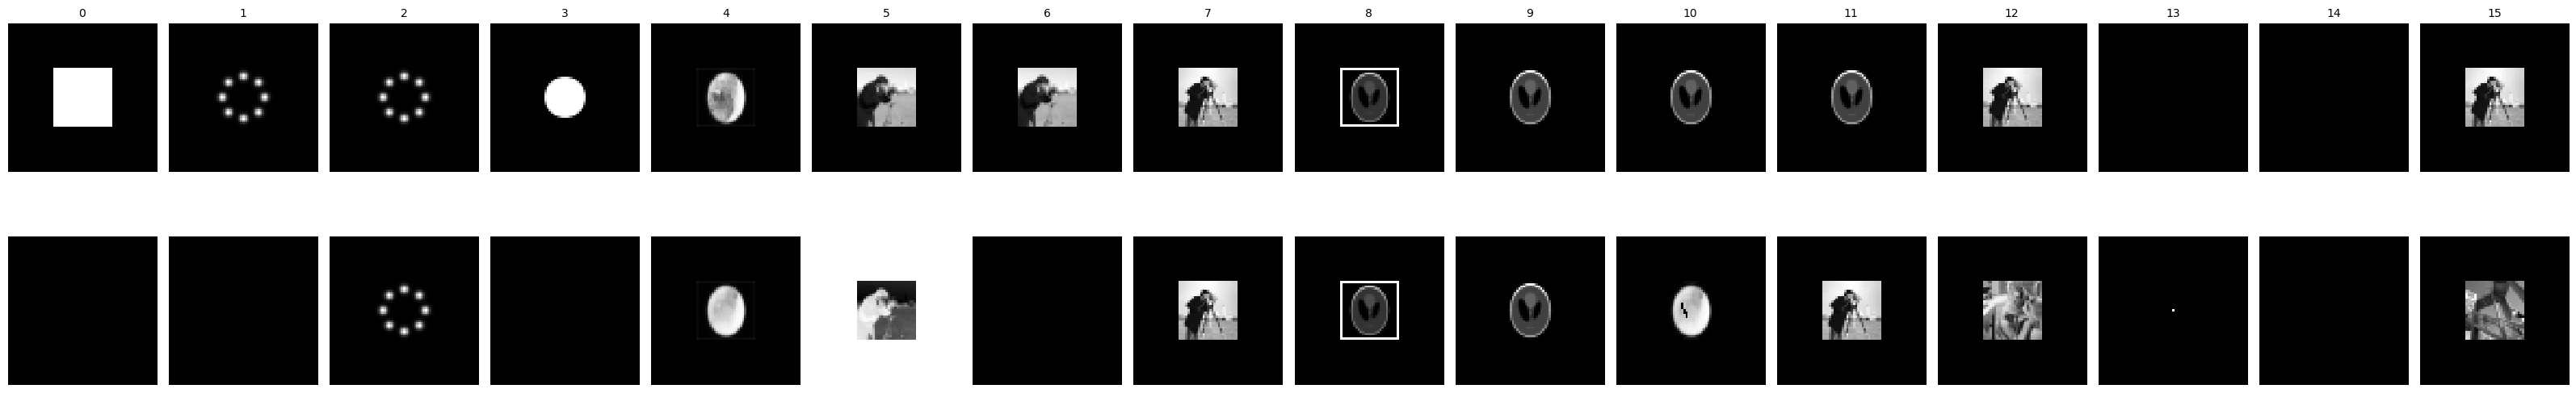

In [54]:
caption = plot_all_test_images(true_images, [])

## Choose a test image, a set of algorithms and parameters' values

In [55]:
idx = [12]  #Select  indices for the test images you wish to use
n = 1  # Number of different values of parameters. Optional. you can also change it manually, for each algorithm.
Algos_group = [
    #['Gerchberg-Saxton',  'No Support prior - fast', 'Error Reduction : support prior']
    #['basic Input-Output', 'Error Reduction + TV-support', 'Gerchberg-Saxton + TV-support']
    #['Hybrid Input-Output real', 'Hybrid Input-Output + TV1', 'Output-Output']
    #['Gaussian-DRS + TV1', 'Gaussian-DRS + TVS_M', 'Gaussian-DRS + M_TVS']
    #['Poisson-DRS in OS + TV1', 'Poisson-DRS + TV1', 'Gaussian-DRS']
    #['Poisson-DRS in OS + M_TVS', 'Peaceman-Rachford RSRM', 'Peaceman-Rachford RMRS'] 
    #[ 'Poisson-DRS + M_TVS', 'Peaceman-Rachford RSRM + TV1'] 
    #['Poisson-DRS in OS', 'Poisson-DRS + TVS_M', 'Poisson-DRS in OS + TVS_M']
    #['Averaged Alternating Reflections RSRM', 'Averaged Alternating Reflections RSRM + TVS_M', 'Averaged Alternating Reflections RSRM + M_TVS']
    #[ 'Averaged Alternating Reflections RSRM + TV1', 'RAAR','new Hybrid Input-Output'] 
    # ['Averaged Alternating Reflections RMRS', 'Averaged Alternating Reflections RMRS + M_TVS', 'Averaged Alternating Reflections RMRS + TV1'] 
    # ['Gaussian-DRS','Gaussian-DRS + M_TVS','Gaussian-DRS + TV1', 'Gaussian-DRS + TVS_M'] #'Gaussian-DRS','Gaussian-DRS + M_TVS', 
    [ 'Gaussian-DRS' ]  #'Gaussian-DRS', 'Poisson-DRS in OS' ,  'Gaussian-DRS + TV1', 'Gaussian-DRS + TVS_M', 'Gaussian-DRS + M_TVS'

    # ['Averaged Alternating Reflections RSRM', 'RAAR', 'Gaussian-DRS' ] #, 'Gaussian-DRS', 'Poisson-DRS in OS'  'Averaged Alternating Reflections RMRS',
    # ['Hybrid Input-Output', 'RAAR', 'Gaussian-DRS' ] #, 'Gaussian-DRS', 'Poisson-DRS in OS'  'Averaged Alternating Reflections RMRS',
    # [ 'Gaussian-DRS', 'Hybrid Input-Output']
    # ['RAAR']
    # ['Averaged Alternating Reflections RSRM','Averaged Alternating Reflections RMRS']
    #['real mirror', 'complex mirror', 'Hybrid Input-Output'], 'RAAR'
]  # Algorithm to run, repeated for each iteration

# Create a list to store all parameters for 'Hybrid Input-Output' with different HIO_beta values
params = {
    'real mirror': [{'xi': 12, 'kappa': kappa} for kappa in [100000, 1000, 10] ],
    'complex mirror': [{'xi': 12, 'kappa': 100000}],

    'Error Reduction : support prior': [{}],
    'Error Reduction + TV-support': [{'TvIter': 10, 'TvAlpha': 0.005}],
    'Gerchberg-Saxton': [{}],
    'Gerchberg-Saxton + TV-support': [{'TvIter': 10, 'TvAlpha': 0.005}],
    'No Support prior - fast': [{}],


    'Hybrid Input-Output': [{'HIO_beta': l} for l in np.linspace(.5, 1, 2)],  # List of parameter sets for each iteration
    'Hybrid Input-Output + TV1': [{'HIO_beta': 1.0, 'TvIter': 10, 'TvAlpha': 0.005}],
    'new Hybrid Input-Output': [{'newHIO_alph_beta_gamm': [0.25, 0.25, 0.5]}],
    'Hybrid Input-Output real': [{'HIO_beta': 1.0}],
    'Output-Output': [{'OO_beta': 0.5}],
    'basic Input-Output': [{'IO_beta': 1.0}],

    'Gaussian-DRS': [{'rho_alph_Gau': [l, 0.5]} for l in [0., 0.1, 0.3, 0.5, 1.1] ], #np.linspace(0, 1, n) [0.1, 0.3, 0.5, 1.1]
    'Gaussian-DRS + TVS_M': [{'rho_alph_Gau':  [l, 0.5], 'TvIter': 10, 'TvAlpha': 0.005} for l in [ 0.3 ] ],
    'Gaussian-DRS + M_TVS': [{'rho_alph_Gau':  [l, 0.5], 'TvIter': 10, 'TvAlpha': 0.005} for l in [ 0.3 ] ],
    'Gaussian-DRS + TV1': [{'rho_alph_Gau':  [l, 0.5], 'TvIter': 10, 'TvAlpha': 0.005} for l in [ 0.3 ] ],
    
    'Poisson-DRS': [{'rho_alph_Poi':  [0, l]} for l in np.linspace(0, 1, n)],
    'Poisson-DRS + TVS_M': [{'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005}],
    'Poisson-DRS + M_TVS': [{'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005}],
    'Poisson-DRS + TV1': [{'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005}],

    'Poisson-DRS in OS': [{'rho_alph_Poi':  [0, l]} for l in np.linspace(0, 1, n)],
    'Poisson-DRS in OS + TVS_M': [{'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005}],
    'Poisson-DRS in OS + M_TVS': [{'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005}],
    'Poisson-DRS in OS + TV1': [{'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005}],
    
    'RAAR': [{'RAAR_beta': l} for l in np.linspace(.9, 1, n)],
    
    'Averaged Alternating Reflections RSRM': [{'AAR_lambda': l} for l in np.linspace(0.5, 0.9, n)],
    'Averaged Alternating Reflections RSRM + TVS_M': [{'TvIter': 10, 'TvAlpha': 0.005}],
    'Averaged Alternating Reflections RSRM + M_TVS': [{'TvIter': 10, 'TvAlpha': 0.005}],
    'Averaged Alternating Reflections RSRM + TV1': [{'TvIter': 10, 'TvAlpha': 0.005}],

    'Averaged Alternating Reflections RMRS': [{'AAR_lambda': l} for l in np.linspace(0.5, 0.8, n)],
    'Averaged Alternating Reflections RMRS + M_TVS': [{'TvIter': 10, 'TvAlpha': 0.005}],
    'Averaged Alternating Reflections RMRS + TV1': [{'TvIter': 10, 'TvAlpha': 0.005}],
    
    'Peaceman-Rachford RSRM': [{'gamma_M': 1, 'gamma_S': 1 }],
    'Peaceman-Rachford RMRS': [{'gamma_M': 1, 'gamma_S': 1}],
    'Peaceman-Rachford RSRM + TV1': [{'gamma_M': 1, 'gamma_S': 1, 'TvIter': 10, 'TvAlpha': 0.005}],

}

## Runs the algorithms and collects results

f_X_sols_fr, RR_fr, Err_fr, RE_fr are full errors

f_X_sols, RR, Err, RE are errors inside the mask, i.e. after projecting onto the support contraint 


In [56]:
# Now call run_algorithms once, passing all the different parameter values at the same time
# print(f"Running 'Hybrid Input-Output' with different HIO_beta values: {params['Hybrid Input-Output']}")
# print(f"Running 'Averaged Alternating Reflections RSRM' with different AAR_lambda values: {params['Averaged Alternating Reflections RSRM']}")
# print(f"Running 'Averaged Alternating Reflections RMRS' with different AAR_lambda values: {params['Averaged Alternating Reflections RMRS']}")
print(f"Running 'Gaussian-DRS' with different rho values: {params['Gaussian-DRS']}")
# print(f"Running 'RAAR' with different RAAR_beta values: {params['RAAR']}")

# Running the algorithm with all parameters
NSR, x_solutions_all, parameters, f_X_sols, RR, Err, RE, image_idx, space, algos, f_X_sols_fr, RR_fr, Err_fr, RE_fr = run_algorithms(true_images, idx, Algos_group, params, noise_lvl = 0., chosen_mask = mask)


Running 'Gaussian-DRS' with different rho values: [{'rho_alph_Gau': [0.0, 0.5]}, {'rho_alph_Gau': [0.1, 0.5]}, {'rho_alph_Gau': [0.3, 0.5]}, {'rho_alph_Gau': [0.5, 0.5]}, {'rho_alph_Gau': [1.1, 0.5]}]
Noise to Signal Ratio (in the 2-norm) : 0.0
Noise to Signal Ratio (in the initialization) : 0.525498629447
noise not to fit : 0.0
iteration k 0
iteration k 100
iteration k 200
iteration k 300
iteration k 400
iteration k 500
iteration k 600
iteration k 700
iteration k 800
iteration k 900
iteration k 0
iteration k 100
iteration k 200
iteration k 300
iteration k 400
iteration k 500
iteration k 600
iteration k 700
iteration k 800
iteration k 900
iteration k 0
iteration k 100
iteration k 200
iteration k 300
iteration k 400
iteration k 500
iteration k 600
iteration k 700
iteration k 800
iteration k 900
iteration k 0
iteration k 100
iteration k 200
iteration k 300
iteration k 400
iteration k 500
iteration k 600
iteration k 700
iteration k 800
iteration k 900
iteration k 0
iteration k 100
iterati

### Plotting function

In [67]:
def phase_retrie_plots_object(idx, grd_truths, X_sols, space, Algos):
    op = odl.FlatteningOperator(space)
    
    fig = plt.figure(figsize=(16, 14))  # (4, 8)
    
    x = grd_truths[idx]
    Nx, Ny = x.shape

    N = len(Algos) + 1
    ax = fig.add_subplot(5, N, 1)
    im = ax.imshow(x.real, vmin=np.min(x.real), vmax=np.max(x.real), interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title('Real Part-Ground Truth', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax)

    ax1 = fig.add_subplot(5, N, 1 + N)
    im = ax1.imshow(x.imag, vmin=np.min(x.imag), vmax=np.max(x.imag), interpolation="nearest", cmap=plt.cm.gray)
    ax1.set_title('Imaginary Part-Ground Truth', fontsize=10)
    ax1.axis('off')
    plt.colorbar(im, ax=ax1)

    # Loop over test images and the algorithms 
    for i, algo in enumerate(Algos):
        x_sol = op.inverse(X_sols[i][-1] ) #- X_sols[1][-1]
        # #correct global phase : close form of the 1D optimizer
        # lambd = np.vdot( X_sols[i][-1], x)
        # phi = np.arctan(lambd.imag/lambd.real)
        # X_sols[i][-1] = np.exp(phi * 1.j) * X_sols[i][-1]
        ax = fig.add_subplot(5, N, i + 2)
        im = ax.imshow(x_sol.real, vmin=np.min(x_sol.real), vmax=np.max(x_sol.real), interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(f' {algo}', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax)
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax1 = fig.add_subplot(5, N, i + 2 + N)
        im = ax1.imshow(x_sol.imag, vmin=np.min(x_sol.imag), vmax=np.max(x_sol.imag), interpolation="nearest", cmap=plt.cm.gray)
        ax1.set_title(f'{algo}', fontsize=10)
        ax1.axis('off')
        plt.colorbar(im, ax=ax1)

    # Create a BytesIO buffer to save the image
    buffer = io.BytesIO()
    
    # Save the plot to the buffer instead of a file
    plt.savefig(buffer, format='png', dpi=300)
    caption = buffer.getvalue()
    buffer.seek(0)
    plt.tight_layout()
    plt.show()
    return caption

## Plots the reconstructions

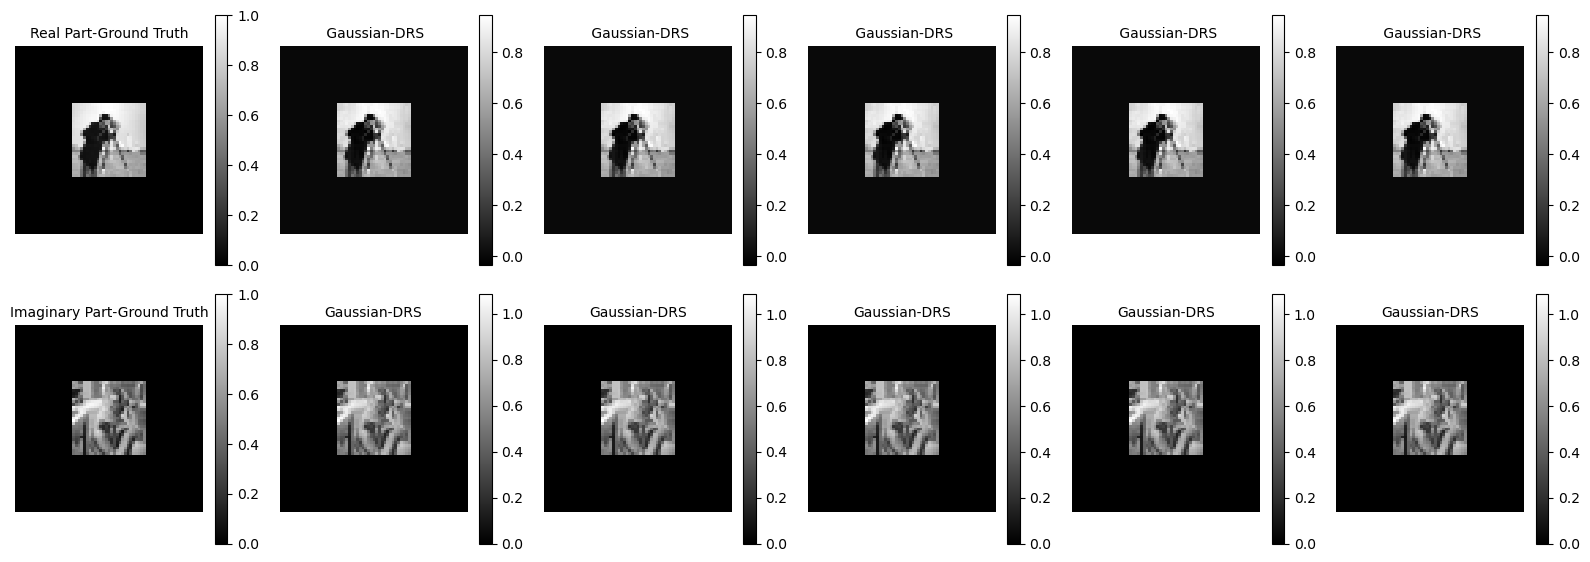

In [68]:
# phase_retrie_plots_objects(image_idx[0], true_images, x_solutions_all[0], space, algos)
caption = phase_retrie_plots_object(image_idx[0], true_images, x_solutions_all[0], space, algos)
# Now you can access the image in memory
# For example, to save it to a file later:
# Define the path
path = 'results_desk/object_image_ratio_4over10/random/noiseless/Gaussian_init/ Gaussian-DRS rho 0., 0.1, 0.3, 0.5, 1.1, mask, imageSize 34_34 times 2, gaussian init.png'
# path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/gaussian_init/ Gaussian-DRS TVS_M 0.005, exact shepp mask, imageSize 84_84 times 2, gaussian init.png'
# path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/gaussian_init/HIO .5, 1, RAAR 1, Gaussian-DRS,  for diff param rho 0 0.25 0.5 0.75 1, exact shepp mask imageSize 84_84 times 2, gaussian init.png'
# path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/gaussian_init/shepp cancer same support, Gauss DRS, 4 over 10, extended shepp mask, 84_84 x 2,noiseless, gaussian init, 1000 iter.png'

# with open(path, 'wb') as f:
#     f.write(caption)


###  Errors plotting function

In [59]:
def plot_error_decay(errors_list, params, title="Error Decay", path = '/path/to/directory/my_plot.png', xlabel="Epoch", ylabel="Error"):
    """
    Plots the error values from multiple iterations for different parameter values.
    
    Parameters:
        errors_list (list of lists): A list of lists, where each inner list contains error values for a specific parameter.
        params (list): A list of parameter values corresponding to each inner list in errors_list.
        title (str): The title of the plot.
        xlabel (str): Label for the x-axis (iteration count).
        ylabel (str): Label for the y-axis (error value).
    """
    plt.figure(figsize=(6, 3))  # Adjust size if needed
    
    # # Loop through each list of errors and corresponding parameter
    # for errors, param in zip(errors_list, params):
    #     plt.loglog(range(1, len(errors) + 1), errors, label=f'Param={param}')

    # Define a list of line styles
    line_styles = ['-', '--', '-.', ':']
    # Loop through each list of errors and corresponding parameter
    for idx, (errors, param) in enumerate(zip(errors_list, params)):
        # Select a line style based on the index (wrap around if needed)
        linestyle = line_styles[idx % len(line_styles)]
        plt.semilogy(range(1, len(errors) + 1), errors, label=f'{param}', linestyle=linestyle)  # semilogy, loglog

    # # Define a list of line styles and markers
    # line_styles = ['-', '--', '-.', ':']
    # markers = ['o', 's', '^', 'D']  # Circle, square, triangle up, diamond
    
    # # Loop through each list of errors and corresponding parameter
    # for idx, (errors, param) in enumerate(zip(errors_list, params)):
    #     # Select a line style and marker based on the index (wrap around if needed)
    #     linestyle = line_styles[idx % len(line_styles)]
    #     marker = markers[idx % len(markers)]
    #     plt.loglog(range(1, len(errors) + 1), errors, label=f'Param={param}', linestyle=linestyle, marker=marker)

    # Adding title and labels
    # plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show legend
    plt.legend(title="Parameters")  #loc = 'center right'
    # Save the plot as a PNG file
    # plt.savefig(path, dpi=300)
    # plt.savefig('my_plot.png', dpi=300)
    # Display the plot
    plt.grid(True)
    # Create a BytesIO buffer to save the image
    buffer = io.BytesIO()
    # Apply tight_layout before saving to ensure labels aren't cropped
    plt.tight_layout()
    # Save the plot to the buffer instead of a file
    plt.savefig(buffer, format='png', dpi=300)
    caption = buffer.getvalue()
    buffer.seek(0)
    plt.show()
    return caption

## Plots the relative errors and relative residuals 
RR and RE and the errors inside the box. 

RR_fr and RE_fr are the full errors

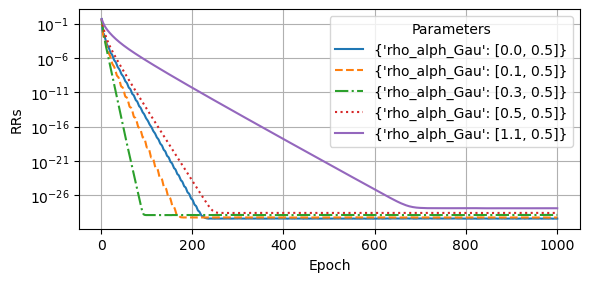

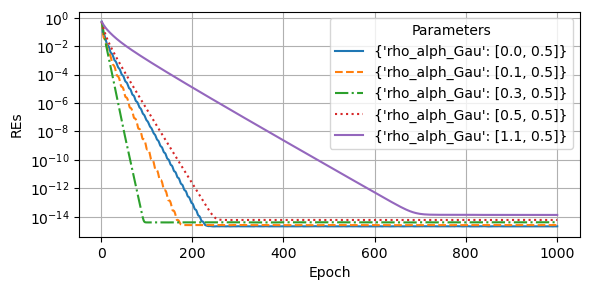

In [64]:
# Example usage:
import os
# Assuming you have a list of lists of error values and a corresponding list of parameter values
errors_list = RR  # RR_fr RR, f_X_sols
# print((f_X_sols[0]), (f_X_sols[1]))
parames = parameters  # Example parameter values

# Define the path
# path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/spectral_init/Gaussian-DRS, spectral init imageSize 64_64, Fourier error for diff param 0 0.25 0.5 0.75 1.png'
# path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/spectral_init/HIO, RAAR, Gaussian-DRS, 10 000 iter, imageSize 84_84 x 2, Fourier error.png'
# path = 'results_desk/object_image_ratio_4over10/random/noiseless/Gaussian_init/Gaussian-DRS, 1000 iter, imageSize 34_34 x 2, Fourier error.png'
path = 'results_desk/object_image_ratio_4over10/random/noiseless/Gaussian_init/Gaussian-DRS, 1000 iter, imageSize 34_34 x 2, Fourier error inside the box.png'

# Get the directory from the path
directory = os.path.dirname(path)

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)
title = 'RRs' # 'RR' 'Fourier error'
caption = plot_error_decay(errors_list, parames, title = title, path = path, xlabel="Epoch", ylabel=title)
# with open(path, 'wb') as f:
#     f.write(caption)

errors_list = RE # RE_fr RE, Err
# print((Err[0]), (Err[1]))

# Define the path
# path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/spectral_init/Gaussian-DRS, imageSize 64_64, Object error for diff param 0 0.25 0.5 0.75 1.png'
# path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/spectral_init/HIO, RAAR, Gaussian-DRS, 1000 iter, imageSize 84_84 x 2, Object error.png'
# path = 'results_desk/object_image_ratio_4over10/random/noiseless/Gaussian_init/Gaussian-DRS, 1000 iter, imageSize 34_34 x 2, Object error.png'
path = 'results_desk/object_image_ratio_4over10/random/noiseless/Gaussian_init/Gaussian-DRS, 1000 iter, imageSize 34_34 x 2, Object error inside the box.png'
title = 'REs' # 'RE' 'Object error'
caption = plot_error_decay(errors_list, parames, title = title, path = path, xlabel="Epoch", ylabel=title)
# with open(path, 'wb') as f:
#     f.write(caption)

## To evaluate tight support effect on the reconstruction

In [ ]:
# evaluate influence of tight support 
# idx = [12] 
# half_Nx, half_Ny = 84, 84
# #half image shape
# Nx, Ny = 2 * half_Nx + 1,  2 * half_Ny + 1 #image shape
# rx, ry = 1, 1 #for oversampling
# n = Nx * Ny #image size
num = 2
delta = (half_Nx - 1) / (num - 1)
X_sols_alls = []
RRs = []
REs = []
true_image_list = []
for k in np.linspace(1, half_Nx, num, dtype=int):

    # object support
    Kx = k # half_Nx #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).  
    Ky = k # half_Ny #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).
    
    # mask support
    tx = 0. #parameter between 0 (very precise) and 1(no support knowledge) # 0.35  failed already
    ty = 0. #parameter between 0 (very precise) and 1(no support knowledge)  
    
    #true_images = setUpImage(Nx, Ny)
    s = setUpImage(Nx, Ny, Kx, Ky, tx, ty)
    
    true_imagesc, maskc, mask_sheppc, exact_mask_sheppc, extended_mask_sheppc, mask_cancerc = s()
    true_image_list.append(true_imagesc[idx[0]])
    NSRc, X_sols_allc, parametersc, f_X_sols, RRc, Errc, REc, image_idxc, spacec, algosc, f_X_sols_fr, RRc_fr, Errc_fr, REc_fr = run_algorithms(true_imagesc, idx, Algos_group, params, noise_lvl = 0, chosen_mask = maskc  )
    X_sols_alls.append(X_sols_allc)
    RRs.append(RRc)
    REs.append(REc)

### Plots reconstructed images for different object's size

In [ ]:
delta = (half_Nx - 1) / (num - 1)
for i, im in enumerate(true_image_list):
    print('object_image_ratio', (1 + i * delta) / half_Nx)
    caption = phase_retrie_plots_object(0, [im], X_sols_alls[i][0], spacec, algosc)
    path = f'results_desk/tight_support/image CiB/Gaussian-DRS rho 0/imageSize 84_84 times 2/neg_conj_not_corrected 100 trials/object_image_ratio varies {1 + i * delta } over {half_Nx}, Gaussian-DRS rho 0, Fourier A, mask, imageSize 84_84 times 2, gaussian init.png'
    # path = f'results_desk/tight_support/image SiC/object_image_ratio varies {1 + i * delta } over {half_Nx}, Gaussian-DRS, random A, mask, imageSize 34_34 times 2, gaussian init.png'
    # Get the directory from the path
    directory = os.path.dirname(path)
    
    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    # with open(path, 'wb') as f:
    #     f.write(caption)

### prepare the errors plotting function

In [ ]:
def plot_error_decay_tight_support(errors_list, params, ratio, title="Error Decay", xlabel="Epoch", ylabel="Error"):
    """
    Plots the error values from multiple iterations for different parameter values.
    
    Parameters:
        errors_list (list of lists): A list of lists, where each inner list contains error values for a specific parameter.
        params (list): A list of parameter values corresponding to each inner list in errors_list.
        title (str): The title of the plot.
        xlabel (str): Label for the x-axis (iteration count).
        ylabel (str): Label for the y-axis (error value).
    """
    plt.figure(figsize=(6, 3))  # Adjust size if needed
    
    # # Loop through each list of errors and corresponding parameter
    # for errors, param in zip(errors_list, params):
    #     plt.loglog(range(1, len(errors) + 1), errors, label=f'Param={param}')

    # Define a list of line styles
    line_styles = ['-', '--', '-.', ':']
    # Loop through each list of errors and corresponding parameter
    for idx, (errors, param) in enumerate(zip(errors_list, params)):
        # Select a line style based on the index (wrap around if needed)
        linestyle = line_styles[idx % len(line_styles)]
        plt.semilogy(ratio, errors, label=f'Param={param}', linestyle=linestyle)  # semilogy, loglog

    # # Define a list of line styles and markers
    # line_styles = ['-', '--', '-.', ':']
    # markers = ['o', 's', '^', 'D']  # Circle, square, triangle up, diamond
    
    # # Loop through each list of errors and corresponding parameter
    # for idx, (errors, param) in enumerate(zip(errors_list, params)):
    #     # Select a line style and marker based on the index (wrap around if needed)
    #     linestyle = line_styles[idx % len(line_styles)]
    #     marker = markers[idx % len(markers)]
    #     plt.loglog(range(1, len(errors) + 1), errors, label=f'Param={param}', linestyle=linestyle, marker=marker)

    # Adding title and labels
    # plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    print( )
    # Show legend
    plt.legend(title="Parameters")
    # plt.savefig(path, dpi=300)

    plt.grid(True)
    # Create a BytesIO buffer to save the image
    buffer = io.BytesIO()
    # Apply tight_layout before saving to ensure labels aren't cropped
    plt.tight_layout()
    # Save the plot to the buffer instead of a file
    plt.savefig(buffer, format='png', dpi=300)
    caption = buffer.getvalue()
    buffer.seek(0)
    # plt.tight_layout()
    plt.show()
    return caption
  

### Plots relative errors and relative residuals as functions of the object-to-image size ratio

In [ ]:
ratio = [ (1 + i * delta) / half_Nx for i in range(num)] 
errors_list = [[sublist[0][-1] for sublist in RRs]]
paramet = parametersc  # Example parameter values
path = 'results_desk/tight_support/image CiB/Gaussian-DRS rho 0/imageSize 84_84 times 2/Fourier error, Gaussian-DRS rho 0, Fourier A, mask, 25 trials, imageSize 84_84 times 2, gaussian init.png'
# path = 'results_desk/tight_support/image SiC/Fourier error, Gaussian-DRS, random A, mask, 25 trials, imageSize 34_34 times 2, gaussian init.png'
# Get the directory from the path
directory = os.path.dirname(path)
# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)
title = 'RR' # 'Fourier error'
caption = plot_error_decay_tight_support(errors_list, paramet, ratio = ratio, title = title, xlabel="ratio : object/image size", ylabel=title)
# with open(path, 'wb') as f:
#     f.write(caption)
errors_list = [[sublist[0][-1] for sublist in REs]]
path = 'results_desk/tight_support/image CiB/Gaussian-DRS rho 0/imageSize 84_84 times 2/ error, Gaussian-DRS rho 0, Fourier A, mask, 25 trials, imageSize 84_84 times 2, gaussian init.png'
# path = 'results_desk/tight_support/image SiC/Object error, Gaussian-DRS, random A, mask, 25 trials, imageSize 34_34 times 2, gaussian init.png'
title = 'RE'#  'Object error'
caption = plot_error_decay_tight_support(errors_list, paramet, ratio = ratio, title = title,  xlabel="ratio : object/image size", ylabel=title)
# with open(path, 'wb') as f:
#     f.write(caption)

## To evaluate the mask's precision effect on the reconstruction

In [ ]:
# evaluate influence of mask precision 
# half_Nx, half_Ny = 34, 34
# #half image shape
# Nx, Ny = 2 * half_Nx + 1,  2 * half_Ny + 1 #image shape
# rx, ry = 1, 1 #for oversampling
# n = Nx * Ny #image size
num = 2  #number of diferent ratios
deltas = (1) / (num - 1)
X_sols_allss = []
RRss = []
REss = []
true_image_listcc = []
for k in np.linspace(0, 1, num):

    # object support
    Kx = half_Nx // 2 # half_Nx #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).  
    Ky = half_Ny // 2 # half_Ny #any natural integer between 0 (object is a single point) and half_Nx (object fills up the full image).
    
    # mask support
    tx = k #parameter between 0 (very precise) and 1(no support knowledge) # 0.35  failed already
    ty = k #parameter between 0 (very precise) and 1(no support knowledge)  
    
    #true_images = setUpImage(Nx, Ny)
    s = setUpImage(Nx, Ny, Kx, Ky, tx, ty)
    
    true_imagess, masks, mask_shepps, exact_mask_shepps, extended_mask_shepps, mask_cancers = s()
    true_image_listcc.append(true_imagess[idx[0]])
    NSRcc, X_sols_allcc, parameterscc, f_X_sols, RRcc, Errcc, REcc, image_idxcc, spacecc, algoscc, f_X_sols_fr, RRcc_fr, Errcc_fr, REcc_fr = run_algorithms(true_imagess, idx, Algos_group, params, noise_lvl = 0, chosen_mask = masks  )
    X_sols_allss.append(X_sols_allcc)
    RRss.append(RRcc)
    REss.append(REcc)

### Plots reconstructed images for different object-to-mask size ratios 

In [ ]:
deltas = (1) / (num - 1)
for i, im in enumerate(true_image_listcc):
    print('object/mask ratio', 1 + i * deltas)
    caption = phase_retrie_plots_object(0, [im], X_sols_allss[i][0], spacecc, algoscc)
    path = f'results_desk/mask precision/image CiB/Gaussian-DRS rho 0/imageSize 84_84 times 2/object_mask_ratio varies over { 1 + i * deltas } , Gaussian-DRS rho 0,  Fourier A, mask, imageSize 84_84 times 2, gaussian init.png'
    # path = f'results_desk/mask precision/image SiC/object_mask_ratio varies over { 1 + i * deltas } , Gaussian-DRS, random A, mask, imageSize 34_34 times 2, gaussian init.png'
    # Get the directory from the path
    directory = os.path.dirname(path)
    
    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    # with open(path, 'wb') as f:
    #     f.write(caption)

### Plots relative errors and relative residuals as functions of the object-to-mask size ratio

In [ ]:
ratios = [ (1 + i * deltas)  for i in range(num)] 
errors_list = [[sublist[0][-1] for sublist in RRss]]
paramete = parameterscc  # Example parameter values
path = 'results_desk/mask precision/image CiB/Gaussian-DRS rho 0/imageSize 84_84 times 2/Fourier error, Gaussian-DRS, random A, mask, imageSize 34_34 times 2, gaussian init.png'
# Get the directory from the path
directory = os.path.dirname(path)
# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)
title = 'RR' # 'Fourier error'
caption = plot_error_decay_tight_support(errors_list, paramete, ratio = ratios, title = title, xlabel="ratio : object/mask size", ylabel=title)
# with open(path, 'wb') as f:
#     f.write(caption)
errors_list = [[sublist[0][-1] for sublist in REss]]
path = 'results_desk/mask precision/image CiB/Gaussian-DRS rho 0/imageSize 84_84 times 2/Object error, Gaussian-DRS, random A, mask, imageSize 34_34 times 2, gaussian init.png'
title = 'RE'#  'Object error'
caption = plot_error_decay_tight_support(errors_list, paramete, ratio = ratios, title = title,  xlabel="ratio : object/mask size", ylabel=title)
# with open(path, 'wb') as f:
#     f.write(caption)

## Ignore everything below 

In [ ]:
x_solutions = []  # To store the solutions
# Extract the results for each parameter value (assuming run_algorithms returns results in a structured way)
for j, image_index in enumerate(idx):
    for i in range(n):
        x_sol = x_solutions_all[j][i][-1]  # Assuming each iteration returns a list, and we want the last element
        x_solutions.append(x_sol)
# parameters
# Now x_solutions contains all the results for each 'Hybrid Input-Output' with different HIO_beta values


In [ ]:
# Example usage
idx = [7]
#true_images = np.arange(10).reshape(10, 1, 1)  # Just a placeholder, replace with actual images
Algos_group = [
    #['Gerchberg-Saxton',  'No Support prior - fast', 'Error Reduction : support prior']
    #['basic Input-Output', 'Error Reduction + TV-support', 'Gerchberg-Saxton + TV-support']
    #['Hybrid Input-Output real', 'Hybrid Input-Output + TV1', 'Output-Output']
    #['Gaussian-DRS + TV1', 'Gaussian-DRS + TVS_M', 'Gaussian-DRS + M_TVS']
    #['Poisson-DRS in OS + TV1', 'Poisson-DRS + TV1', 'Gaussian-DRS']
    #['Poisson-DRS in OS + M_TVS', 'Peaceman-Rachford RSRM', 'Peaceman-Rachford RMRS'] 
    #[ 'Poisson-DRS + M_TVS', 'Peaceman-Rachford RSRM + TV1'] 
    #['Poisson-DRS in OS', 'Poisson-DRS + TVS_M', 'Poisson-DRS in OS + TVS_M']
    #['Averaged Alternating Reflections RSRM', 'Averaged Alternating Reflections RSRM + TVS_M', 'Averaged Alternating Reflections RSRM + M_TVS']
    #[ 'Averaged Alternating Reflections RSRM + TV1', 'RAAR','new Hybrid Input-Output'] 
    #['Averaged Alternating Reflections RMRS', 'Averaged Alternating Reflections RMRS + M_TVS', 'Averaged Alternating Reflections RMRS + TV1'] 
    ['Hybrid Input-Output'] #, 'Gaussian-DRS', 'Poisson-DRS in OS'
    #['real mirror', 'complex mirror', 'Hybrid Input-Output'],
    # Add other groups as needed
]

list = []
for l in np.linspace(0,1,5):
    params = {
        
        'Hybrid Input-Output': {'HIO_beta': l},
    }
    print('HIO_beta : ',l)
    # x_sol = run_algorithms(true_images, idx, Algos_group, params)[0][-1] #X_sols_all =
    # list.append(x_sol)


In [ ]:
# Example usage
idx = [7]
#true_images = np.arange(10).reshape(10, 1, 1)  # Just a placeholder, replace with actual images
Algos_group = [
    #['Gerchberg-Saxton',  'No Support prior - fast', 'Error Reduction : support prior']
    #['basic Input-Output', 'Error Reduction + TV-support', 'Gerchberg-Saxton + TV-support']
    #['Hybrid Input-Output real', 'Hybrid Input-Output + TV1', 'Output-Output']
    #['Gaussian-DRS + TV1', 'Gaussian-DRS + TVS_M', 'Gaussian-DRS + M_TVS']
    #['Poisson-DRS in OS + TV1', 'Poisson-DRS + TV1', 'Gaussian-DRS']
    #['Poisson-DRS in OS + M_TVS', 'Peaceman-Rachford RSRM', 'Peaceman-Rachford RMRS'] 
    #[ 'Poisson-DRS + M_TVS', 'Peaceman-Rachford RSRM + TV1'] 
    #['Poisson-DRS in OS', 'Poisson-DRS + TVS_M', 'Poisson-DRS in OS + TVS_M']
    #['Averaged Alternating Reflections RSRM', 'Averaged Alternating Reflections RSRM + TVS_M', 'Averaged Alternating Reflections RSRM + M_TVS']
    #[ 'Averaged Alternating Reflections RSRM + TV1', 'RAAR','new Hybrid Input-Output'] 
    #['Averaged Alternating Reflections RMRS', 'Averaged Alternating Reflections RMRS + M_TVS', 'Averaged Alternating Reflections RMRS + TV1'] 
    ['Hybrid Input-Output', 'Gaussian-DRS', 'Poisson-DRS in OS']
    #['real mirror', 'complex mirror', 'Hybrid Input-Output'],
    # Add other groups as needed
]

params = {
    'real mirror': {'xi': 12, 'kappa': 100000},
    'complex mirror': {'xi': 12, 'kappa': 100000},

    'Error Reduction : support prior': {},
    'Error Reduction + TV-support': {'TvIter': 10, 'TvAlpha': 0.005},
    'Gerchberg-Saxton': {},
    'Gerchberg-Saxton + TV-support': {'TvIter': 10, 'TvAlpha': 0.005},
    'No Support prior - fast': {},


    'Hybrid Input-Output': {'HIO_beta': 1.0},
    'Hybrid Input-Output + TV1': {'HIO_beta': 1.0, 'TvIter': 10, 'TvAlpha': 0.005},
    'new Hybrid Input-Output': {'newHIO_alph_beta_gamm': [0.25, 0.25, 0.5]},
    'Hybrid Input-Output real': {'HIO_beta': 1.0},
    'Output-Output': {'OO_beta': 0.5},
    'basic Input-Output': {'IO_beta': 1.0},

    'Gaussian-DRS': {'rho_alph_Gau': [1, 0.5]},
    'Gaussian-DRS + TVS_M': {'rho_alph_Gau':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    'Gaussian-DRS + M_TVS': {'rho_alph_Gau':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    'Gaussian-DRS + TV1': {'rho_alph_Gau':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    
    'Poisson-DRS': {'rho_alph_Poi':  [1, 0.5]},
    'Poisson-DRS + TVS_M': {'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    'Poisson-DRS + M_TVS': {'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    'Poisson-DRS + TV1': {'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},

    'Poisson-DRS in OS': {'rho_alph_Poi':  [1, 0.5]},
    'Poisson-DRS in OS + TVS_M': {'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    'Poisson-DRS in OS + M_TVS': {'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    'Poisson-DRS in OS + TV1': {'rho_alph_Poi':  [1, 0.5], 'TvIter': 10, 'TvAlpha': 0.005},
    
    'RAAR': {'RAAR_beta': 0.5},
    
    'Averaged Alternating Reflections RSRM': {'AAR_lambda': 1},
    'Averaged Alternating Reflections RSRM + TVS_M': {'TvIter': 10, 'TvAlpha': 0.005},
    'Averaged Alternating Reflections RSRM + M_TVS': {'TvIter': 10, 'TvAlpha': 0.005},
    'Averaged Alternating Reflections RSRM + TV1': {'TvIter': 10, 'TvAlpha': 0.005},

    'Averaged Alternating Reflections RMRS': {'AAR_lambda': 1},
    'Averaged Alternating Reflections RMRS + M_TVS': {'TvIter': 10, 'TvAlpha': 0.005},
    'Averaged Alternating Reflections RMRS + TV1': {'TvIter': 10, 'TvAlpha': 0.005},
    
    'Peaceman-Rachford RSRM': {'gamma_M': 1, 'gamma_S': 1 },
    'Peaceman-Rachford RMRS': {'gamma_M': 1, 'gamma_S': 1},
    'Peaceman-Rachford RSRM + TV1': {'gamma_M': 1, 'gamma_S': 1, 'TvIter': 10, 'TvAlpha': 0.005},

    
    # Add other algorithm parameters as needed
}

# run_algorithms(true_images, idx, Algos_group, params) #X_sols_all = 


In [ ]:
def plot_tight_support(idx, grd_truths, X_sols, space, Algos):
    op = odl.FlatteningOperator(space)
    
    fig = plt.figure(figsize=(32, 32))
    
    x = grd_truths[idx]
    Nx, Ny = x.shape

    N = len(Algos) + 1
    ax = fig.add_subplot(5, N, 1)
    im = ax.imshow(x.real, vmin=np.min(x.real), vmax=np.max(x.real), interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title('Real Part-Ground Truth', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax)

    ax1 = fig.add_subplot(5, N, 1 + N)
    im = ax1.imshow(x.imag, vmin=np.min(x.imag), vmax=np.max(x.imag), interpolation="nearest", cmap=plt.cm.gray)
    ax1.set_title('Imaginary Part-Ground Truth', fontsize=10)
    ax1.axis('off')
    plt.colorbar(im, ax=ax1)

    N = len()
    for i 
    for x in (X_sols):
        
    # Loop over test images and the algorithms 
    for i, algo in enumerate(Algos):
        
        x_sol = op.inverse(X_sols[i][-1] ) #- X_sols[1][-1]
        # #correct global phase : close form of the 1D optimizer
        # lambd = np.vdot( X_sols[i][-1], x)
        # phi = np.arctan(lambd.imag/lambd.real)
        # X_sols[i][-1] = np.exp(phi * 1.j) * X_sols[i][-1]
        ax = fig.add_subplot(5, N, i + 2)
        im = ax.imshow(x_sol.real, vmin=np.min(x_sol.real), vmax=np.max(x_sol.real), interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(f' {algo}', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax)
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax1 = fig.add_subplot(5, N, i + 2 + N)
        im = ax1.imshow(x_sol.imag, vmin=np.min(x_sol.imag), vmax=np.max(x_sol.imag), interpolation="nearest", cmap=plt.cm.gray)
        ax1.set_title(f'{algo}', fontsize=10)
        ax1.axis('off')
        plt.colorbar(im, ax=ax1)

    # Create a BytesIO buffer to save the image
    buffer = io.BytesIO()
    
    # Save the plot to the buffer instead of a file
    plt.savefig(buffer, format='png', dpi=300)
    caption = buffer.getvalue()
    buffer.seek(0)
    plt.tight_layout()
    plt.show()
    return caption

    
caption = plot_tight_support(image_idx[0], true_image_list, X_sols_alls[:, 0],  space, algos) # x_solutions_all[0],

path = 'results_desk/object_image_ratio_4over10/Fourier/noiseless/gaussian_init/ Gaussian-DRS TVS_M 0.005, exact shepp mask, imageSize 84_84 times 2, gaussian init.png'
# with open(path, 'wb') as f:
#     f.write(caption)